## Fairness-Aware ML: Student Recommendation Demo

In this notebook, we explore fairness in machine learning, specifically evaluating bias in a recommendation system that selects students for a competitive computer science program.

We'll consider fairness with respect to public vs. private school students, using two definitions:
* Demographic Parity (Equal selection rates)
* Equalized Odds (Equal true positive and false positive rates)

We'll also apply fairness mitigation using ThresholdOptimizer from Fairlearn.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
from sklearn.metrics import accuracy_score
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import true_positive_rate, false_positive_rate



np.random.seed(0)
n_samples = 1000

### Simulate Student Data

In [2]:
school_type = np.random.choice(['public', 'private'], size=n_samples, p=[0.7, 0.3])

test_score = np.random.normal(1100, 100, n_samples) + (school_type == 'private') * 100
test_score = np.clip(test_score, 400, 1600)
gpa = np.random.normal(3.0, 0.4, n_samples) + (school_type == 'private') * 0.2
gpa = np.clip(gpa, 0, 4)
math_grade = np.random.normal(75, 10, n_samples) + (school_type == 'private') * 5
math_grade = np.clip(math_grade, 0, 100)
competitions = np.random.poisson(1, n_samples) + (school_type == 'private') * 0.5

score = 0.4 * gpa + 0.3 * (math_grade / 100) + 0.2 * (test_score / 1600) + 0.1 * competitions
score += (school_type == 'private') * 0.2

y = (score > 1.8).astype(int)

flip_mask = (school_type == 'public') & (np.random.rand(n_samples) < 0.2)
y[flip_mask] = 1 - y[flip_mask]

df = pd.DataFrame({
    'gpa': gpa,
    'math_grade': math_grade,
    'test_score': test_score,
    'competitions': competitions,
    'school_type': school_type,
    'recommend': y
})

df.head()


,gpa,math_grade,test_score,competitions,school_type,recommend
0,3.400532,63.355515,1089.830273,0.0,public,0
1,3.438885,67.214862,1201.927938,0.5,private,1
2,2.673890,64.551837,1284.959125,3.0,public,0
3,3.720486,82.899049,1078.583334,0.0,public,1
4,3.086096,86.022826,1050.098336,0.0,public,1


### Train-Test Split

In [3]:

X = df[['gpa', 'math_grade', 'test_score', 'competitions']]
y = df['recommend']
sf = df['school_type']

X_train, X_test, y_train, y_test, sf_train, sf_test = train_test_split(
    X, y, sf, test_size=0.3, random_state=42
)


### Train Baseline Logistic Regression Model

In [4]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mf = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=sf_test)
print("Baseline accuracy per group:")
print(mf.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sf_test)
eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sf_test)

print(f"\nBaseline Demographic Parity Difference: {dp_diff:.4f}")
print(f"Baseline Equalized Odds Difference: {eo_diff:.4f}")


Baseline accuracy per group:
school_type
private    0.915663
public     0.672811
Name: accuracy_score, dtype: object

Baseline Demographic Parity Difference: 0.3783
Baseline Equalized Odds Difference: 0.3386


### Baseline Selection Rates

In [5]:
selection_rates = pd.DataFrame({'school_type': sf_test.values, 'y_pred': y_pred}).groupby('school_type')['y_pred'].mean()
print("\nSelection rates (Baseline):")
print(selection_rates)



Selection rates (Baseline):
school_type
private    0.746988
public     0.368664
Name: y_pred, dtype: float64


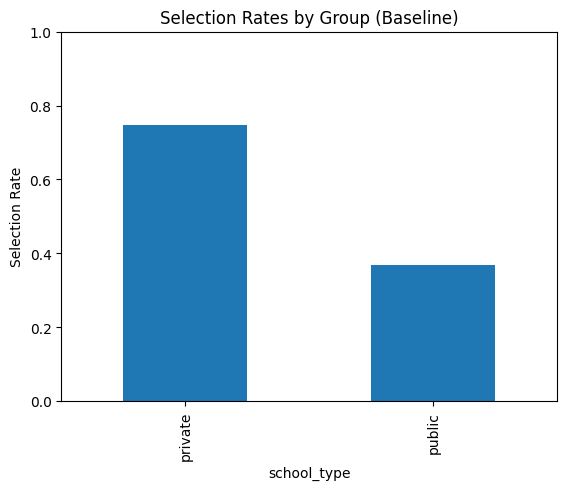

In [6]:
selection_rates.plot(kind='bar', ylim=(0,1), ylabel='Selection Rate', title='Selection Rates by Group (Baseline)')
plt.show()


### Apply Fairness Mitigation: Demographic Parity

In [7]:
threshold_opt_dp = ThresholdOptimizer(estimator=model, constraints='demographic_parity', predict_method='predict_proba')
threshold_opt_dp.fit(X_train, y_train, sensitive_features=sf_train)
y_pred_dp = threshold_opt_dp.predict(X_test, sensitive_features=sf_test)

mf_dp = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred_dp, sensitive_features=sf_test)
dp_diff_post = demographic_parity_difference(y_test, y_pred_dp, sensitive_features=sf_test)

print("\nAccuracy per group (DP mitigation):")
print(mf_dp.by_group)
print(f"Demographic Parity Difference after mitigation: {dp_diff_post:.4f}")



Accuracy per group (DP mitigation):
school_type
private    0.481928
public     0.677419
Name: accuracy_score, dtype: object
Demographic Parity Difference after mitigation: 0.0416


### Selection Rates after Demographic Parity Mitigation

In [8]:
selection_rates_dp = pd.DataFrame({'school_type': sf_test.values, 'y_pred_dp': y_pred_dp}).groupby('school_type')['y_pred_dp'].mean()
print("\nSelection rates (After Demographic Parity):")
print(selection_rates_dp)



Selection rates (After Demographic Parity):
school_type
private    0.313253
public     0.354839
Name: y_pred_dp, dtype: float64


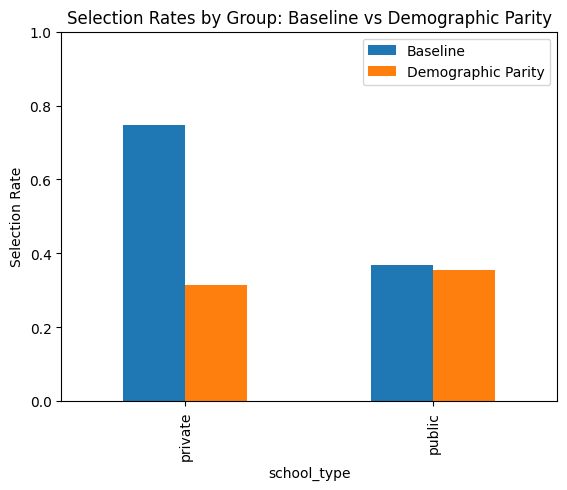

In [9]:
pd.DataFrame({
    'Baseline': selection_rates,
    'Demographic Parity': selection_rates_dp
}).plot(kind='bar', ylim=(0,1), ylabel='Selection Rate', title='Selection Rates by Group: Baseline vs Demographic Parity')
plt.show()


### Apply Fairness Mitigation: Equalized Odds

In [10]:
threshold_opt_eo = ThresholdOptimizer(estimator=model, constraints='equalized_odds', predict_method='predict_proba')
threshold_opt_eo.fit(X_train, y_train, sensitive_features=sf_train)
y_pred_eo = threshold_opt_eo.predict(X_test, sensitive_features=sf_test)

mf_eo = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred_eo, sensitive_features=sf_test)
eo_diff_post = equalized_odds_difference(y_test, y_pred_eo, sensitive_features=sf_test)

print("\nAccuracy per group (EO mitigation):")
print(mf_eo.by_group)
print(f"Equalized Odds Difference after mitigation: {eo_diff_post:.4f}")



Accuracy per group (EO mitigation):
school_type
private    0.650602
public     0.677419
Name: accuracy_score, dtype: object
Equalized Odds Difference after mitigation: 0.1055


### True Positive Rate (TPR) & False Positive Rate (FPR): Baseline vs EO Mitigation

In [11]:
tpr_baseline = MetricFrame(metrics=true_positive_rate, y_true=y_test, y_pred=y_pred, sensitive_features=sf_test)
tpr_eo = MetricFrame(metrics=true_positive_rate, y_true=y_test, y_pred=y_pred_eo, sensitive_features=sf_test)

print("\nTrue Positive Rate (Baseline):")
print(tpr_baseline.by_group)
print("True Positive Rate (EO):")
print(tpr_eo.by_group)



True Positive Rate (Baseline):
school_type
private    0.898551
public         0.56
Name: true_positive_rate, dtype: object
True Positive Rate (EO):
school_type
private    0.652174
public     0.546667
Name: true_positive_rate, dtype: object


In [12]:
fpr_baseline = MetricFrame(metrics=false_positive_rate, y_true=y_test, y_pred=y_pred, sensitive_features=sf_test)
fpr_eo = MetricFrame(metrics=false_positive_rate, y_true=y_test, y_pred=y_pred_eo, sensitive_features=sf_test)

print("\nFalse Positive Rate (Baseline):")
print(fpr_baseline.by_group)
print("False Positive Rate (EO):")
print(fpr_eo.by_group)



False Positive Rate (Baseline):
school_type
private         0.0
public     0.267606
Name: false_positive_rate, dtype: object
False Positive Rate (EO):
school_type
private    0.357143
public     0.253521
Name: false_positive_rate, dtype: object


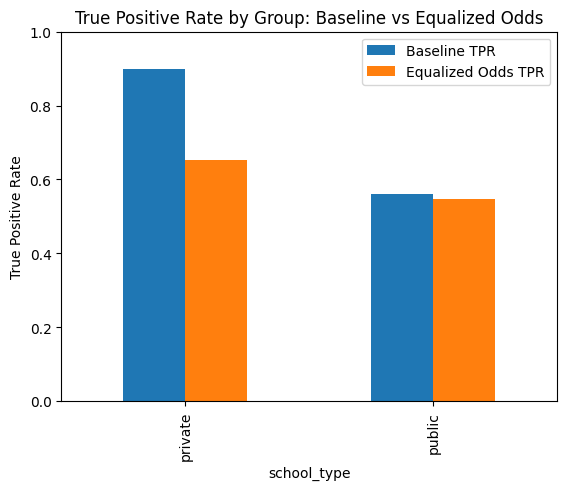

In [13]:
pd.DataFrame({
    'Baseline TPR': tpr_baseline.by_group,
    'Equalized Odds TPR': tpr_eo.by_group
}).plot(kind='bar', ylim=(0,1), ylabel='True Positive Rate', title='True Positive Rate by Group: Baseline vs Equalized Odds')
plt.show()


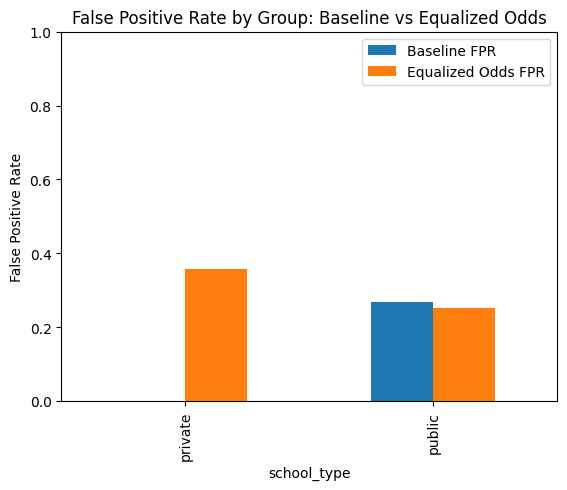

In [14]:
pd.DataFrame({
    'Baseline FPR': fpr_baseline.by_group,
    'Equalized Odds FPR': fpr_eo.by_group
}).plot(kind='bar', ylim=(0,1), ylabel='False Positive Rate', title='False Positive Rate by Group: Baseline vs Equalized Odds')
plt.show()
